<a href="https://colab.research.google.com/github/TS0713/100-Days-ComputerVision/blob/main/TransferLearning_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os 
os.getcwd()
path = "/content/drive/MyDrive/Datasets"
os.chdir(path)
!pip install idx2numpy

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7917 sha256=22a8bbcb8fa2251513a9962f743bff1e5d8b7d2d968b6a94e09c262c246d0ef0
  Stored in directory: /root/.cache/pip/wheels/1a/ce/ad/d5e95a35cfe34149aade5e500f2edd535c0566d79e9a8e1d8a
Successfully built idx2numpy


In [4]:
import numpy as np
import idx2numpy
import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt 
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout

In [5]:
data_path = path+"/MNIST_dataset/"
train_x = idx2numpy.convert_from_file(data_path+"train-images.idx3-ubyte")
train_x  = train_x.reshape(*train_x.shape,1) # 60000, 28, 28
train_y = idx2numpy.convert_from_file(data_path+"train-labels.idx1-ubyte")
train_y = to_categorical(train_y)
test_x = idx2numpy.convert_from_file(data_path+"t10k-images.idx3-ubyte")
test_x = test_x.reshape(*test_x.shape,1) # 60000, 28, 28
test_y = idx2numpy.convert_from_file(data_path+"t10k-labels.idx1-ubyte")
test_y = to_categorical(test_y)

Reference Link: https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/ 

In [93]:
def create_transfer_model(
                       input_shape,
                       n_classes, 
                       model_name=VGG16,
                       include_top=False,
                       optimizer='rmsprop', 
                       fine_tune=0):

  base_transfer_model = model_name(include_top=include_top,
                              weights="imagenet",
                              input_shape=input_shape)
  
  if fine_tune > 0:
    for layer in base_transfer_model.layers[:-fine_tune]:
      layer.trainable=False
  else:
    for layer in base_transfer_model.layers:
      layer.trainable=False
  

  FC_model = base_transfer_model.output
  FC_model = Flatten(name="flatten")(FC_model)
  FC_model = Dense(4096,activation="relu")(FC_model)
  FC_model = Dense(1072,activation="relu")(FC_model)
  FC_model = Dropout(0.2)(FC_model)
  output_layer  = Dense(n_classes,activation="softmax")(FC_model)

  model = Model(inputs=base_transfer_model.input,outputs=output_layer)

  model.compile(optimizer=optimizer,
                loss="categorical_crossentropy",
                metrics=["accuracy"])
  return model


In [94]:
input_shape = (32, 32, 3)
optimizer_ = Adam(learning_rate=0.001)
n_classes=test_y.shape[1]
vgg_transfer_model = create_transfer_model(input_shape=input_shape,
                                           n_classes=n_classes,
                                           model_name=VGG16,
                                           optimizer=optimizer_,
                                           fine_tune=0)

vgg_transfer_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [95]:
def image_preprocess(inp_images,input_shape):

  inp_images = np.array([cv2.cvtColor(i,cv2.COLOR_GRAY2RGB) for i in inp_images])
  inp_images = [Image.fromarray(i) for i in inp_images]
  inp_images = [np.array(i.resize(input_shape,Image.BILINEAR)) for i in inp_images]
  inp_images = np.array(inp_images)
  return inp_images



In [96]:
train_x_rgb = image_preprocess(train_x,(32,32))
test_x_rgb = image_preprocess(test_x,(32,32))

In [97]:
vgg_history = vgg_transfer_model.fit(train_x_rgb[:5000],train_y[:5000],
                            batch_size=64,
                            epochs=10,
                            validation_data=(test_x_rgb,test_y),
                            callbacks=[EarlyStopping(monitor="val_loss",patience=10)],
                            verbose=1)

Epoch 1/10
79/79 [==============================] - 117s 1s/step - loss: 3.2213 - accuracy: 0.7528 - val_loss: 0.4085 - val_accuracy: 0.8644
Epoch 2/10
79/79 [==============================] - 113s 1s/step - loss: 0.2967 - accuracy: 0.9040 - val_loss: 0.3191 - val_accuracy: 0.8941
Epoch 3/10
79/79 [==============================] - 114s 1s/step - loss: 0.2265 - accuracy: 0.9262 - val_loss: 0.2507 - val_accuracy: 0.9181
Epoch 4/10
79/79 [==============================] - 113s 1s/step - loss: 0.1816 - accuracy: 0.9396 - val_loss: 0.2587 - val_accuracy: 0.9218
Epoch 5/10
79/79 [==============================] - 114s 1s/step - loss: 0.1400 - accuracy: 0.9566 - val_loss: 0.2601 - val_accuracy: 0.9209
Epoch 6/10
79/79 [==============================] - 113s 1s/step - loss: 0.1030 - accuracy: 0.9668 - val_loss: 0.3306 - val_accuracy: 0.9067
Epoch 7/10
79/79 [==============================] - 115s 1s/step - loss: 0.0952 - accuracy: 0.9670 - val_loss: 0.2706 - val_accuracy: 0.9234
Epoch 8/10
79

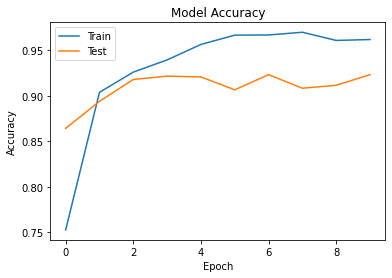

In [98]:
import matplotlib.pyplot as plt
plt.plot(vgg_history.history["accuracy"])
plt.plot(vgg_history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Test"],loc="upper left")
plt.show()

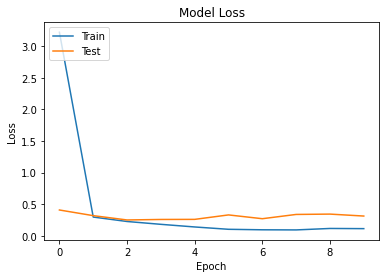

In [99]:
plt.plot(vgg_history.history["loss"])
plt.plot(vgg_history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Test"],loc="upper left")
plt.show()